<a href="https://colab.research.google.com/github/EmilioDeniz/Chess-IA/blob/main/chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de piezas de ajedrez

La intención es crear un red neuronal capaz de reconocer piezas de ajedrez.Para ello se ha utilizado un directorio almacenado en Google Drive, el cual requiere permiso para ser leido.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora ya es accesible

¿Estoy realmente utilizando una GPU? Se comprueba en Editar / Configuración del cuaderno o Entorno de ejecución / Cambiar tipo de entorno de ejecución

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

Veamos una imagen de ejemplo.

bishop	knight	pawn  queen  rook


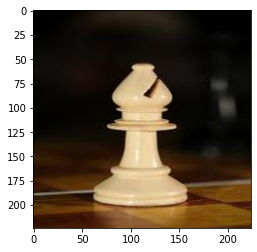

In [ ]:
!ls "/content/drive/My Drive/chess/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/MyDrive/chess/bishop/00000014_resized.jpg', 'r')
imshow(np.asarray(pil_im))


# DATA AUGMENTATION

Este zona de código lo que hace es aumentar las imagenes que tenemos inviertiendo las existentes, dandole la vuelta, etc. Esto nos ayudará a tener mas muestras con las que poder entrenar a la maquina y asi tener un menor margen de error.

In [ ]:
# DATA AUGMETATION

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import glob

datagen = ImageDataGenerator(
  horizontal_flip=False,
    vertical_flip=False,
    rotation_range=25,
    zoom_range=0.20,
    shear_range=0.20,
    fill_mode="nearest")

for i in range(0, 5, 1):
  clases=("bishop","knight","pawn","queen","rook")
  for name in glob.glob("/content/drive/My Drive/Colab Notebooks/chess/"+clases[i]+"/*.jpg"):
    #print("/content/drive/My Drive/Colab Notebooks/chess/"+clases[i]+"/*.jpg")
    img = load_img(name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/drive/My Drive/Colab Notebooks/chess/"+clases[i]+"/da/", 
                              save_prefix="image", save_format='jpg'):
      j += 1
      if j >= 2:
        break
print("Finalización del aumento de datos")

Finalización del aumento de datos


## Primer modelo

In [ ]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chess",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chess",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 5581 files belonging to 5 classes.
Using 4465 files for training.
Found 5581 files belonging to 5 classes.
Using 1116 files for validation.


In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
140/140 [==============================] - 584s 4s/step - loss: 1.5899 - accuracy: 0.2638 - val_loss: 1.5669 - val_accuracy: 0.3127
Epoch 2/200
140/140 [==============================] - 161s 1s/step - loss: 1.5265 - accuracy: 0.3158 - val_loss: 1.4196 - val_accuracy: 0.4211
Epoch 3/200
140/140 [==============================] - 161s 1s/step - loss: 1.3511 - accuracy: 0.4305 - val_loss: 1.0345 - val_accuracy: 0.6353
Epoch 4/200
140/140 [==============================] - 161s 1s/step - loss: 1.0535 - accuracy: 0.5863 - val_loss: 0.7535 - val_accuracy: 0.7375
Epoch 5/200
140/140 [==============================] - 160s 1s/step - loss: 0.8401 - accuracy: 0.6838 - val_loss: 0.6352 - val_accuracy: 0.7760
Epoch 6/200
140/140 [==============================] - 160s 1s/step - loss: 0.7266 - accuracy: 0.7375 - val_loss: 0.5265 - val_accuracy: 0.8181
Epoch 7/200
140/140 [==============================] - 160s 1s/step - loss: 0.6045 - accuracy: 0.7760 - val_loss: 0.4398 - val_accuracy:

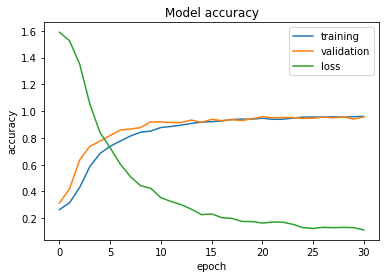

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 347ms/step
              precision    recall  f1-score   support

           0     0.9339    0.9576    0.9456       236
           1     0.9761    0.9630    0.9695       297
           2     0.9357    0.9291    0.9324       141
           3     0.9679    0.9235    0.9452       196
           4     0.9606    0.9919    0.9760       246

    accuracy                         0.9570      1116
   macro avg     0.9549    0.9530    0.9537      1116
weighted avg     0.9572    0.9570    0.9569      1116



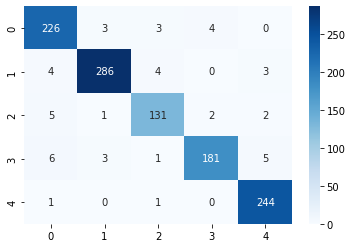

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))